In [1]:
from tqdm import tqdm
import mpramnist
from mpramnist.vikramjointdataset import VikramJointDataset

import mpramnist.transforms as t
import mpramnist.target_transforms as t_t

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
NUM_EPOCHS = 50
BATCH_SIZE = 1024
NUM_WORKERS = 16
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
left_flank = VikramJointDataset.LEFT_FLANK # original flanks from human_legnet
right_flank = VikramJointDataset.RIGHT_FLANK

cuda


## First, we read the MPRAdata, preprocess them and encapsulate them into dataloader form.

In [3]:
# preprocessing
train_transform = t.Compose([
    t.AddFlanks("", right_flank), # this is original parameters for human_legnet
    t.RightCrop(230,250),
    t.RandomCrop(230),
    t.Seq2Tensor(),
    t.Reverse(0.5),

])
test_transform = t.Compose([ # трансформы теста слегка другие
    t.Seq2Tensor(), 

])
test_transform_rev = t.Compose([ # трансформы теста слегка другие
    t.Seq2Tensor(), 
    t.Reverse(1)
])

#activity_columns=["HepG2","K562", "WTC11"]
activity_columns=["HepG2","K562","WTC11"]
# load the data
train_dataset = VikramJointDataset(cell_type = activity_columns, split="train", transform=train_transform) # could use a list e.g. [1,2,5,6,7,8]                                                                                             # for needed folds
val_dataset = VikramJointDataset(cell_type =activity_columns, split="val", transform=test_transform) # use "val" for default validation set

test_dataset = VikramJointDataset(cell_type = activity_columns, split="test", transform=test_transform) # use "test" for default test set
test_dataset_rev = VikramJointDataset(cell_type = activity_columns, split="test", transform=test_transform_rev) 

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader_rev = data.DataLoader(dataset=test_dataset_rev, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [4]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset VikramJointDataset of size 44264 (MpraDaraset)
    Number of datapoints: 44264
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 7, 8', 'val': 9, 'test': 10}
    Used split fold: [1, 2, 3, 4, 5, 6, 7, 8]
    Scalar features: {}
    Vector features: {}
    Cell types: ['HepG2', 'K562', 'WTC11']
    Сell type used: ['HepG2', 'K562', 'WTC11']
    Target columns that can be used: {'HepG2', 'K562', 'WTC11'}
    Number of channels: 4
    Sequence size: 230
    Number of samples: {'train': 1, 'val': 1, 'test': 1}
    Description: 
Dataset VikramJointDataset of size 5541 (MpraDaraset)
    Number of datapoints: 5541
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 7, 8', 'val': 9, 'test': 10}
    Used split fold: [10]
    Scalar features: {}
    Vector features: {}
    Cell types: ['HepG2', 'K562', 'WTC11']
    Сell type used: ['HepG2', 'K562', 'WTC11']
    Target columns that can be used: {'HepG2', 'K562', 'WTC11'}
    Number of channels: 4
    Sequence size: 230
    Number of

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [5]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class SELayer(nn.Module):
    def __init__(self, inp, reduction=4):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
                nn.Linear(inp, int(inp // reduction)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction), inp),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

class EffBlock(nn.Module):
    def __init__(self, in_ch, ks, resize_factor, activation, out_ch=None, se_reduction=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.resize_factor = resize_factor
        self.se_reduction = resize_factor if se_reduction is None else se_reduction
        self.ks = ks
        self.inner_dim = self.in_ch * self.resize_factor

        block = nn.Sequential(
                        nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.inner_dim,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),

                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.inner_dim,
                            kernel_size=ks,
                            groups=self.inner_dim,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),
                       SELayer(self.inner_dim, reduction=self.se_reduction),
                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.in_ch,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.in_ch),
                       activation(),
        )

        self.block = block

    def forward(self, x):
        return self.block(x)

class LocalBlock(nn.Module):
    def __init__(self, in_ch, ks, activation, out_ch=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.ks = ks

        self.block = nn.Sequential(
                       nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.out_ch,
                            kernel_size=self.ks,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.out_ch),
                       activation()
        )

    def forward(self, x):
        return self.block(x)

class ResidualConcat(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return torch.concat([self.fn(x, **kwargs), x], dim=1)

class MapperBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.SiLU):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Conv1d(in_channels=in_features,
                      out_channels=out_features,
                      kernel_size=1),
        )

    def forward(self, x):
        return self.block(x)

class HumanLegNet(nn.Module):
    def __init__(self,
                 in_ch,
                 output_dim,
                 stem_ch,
                 stem_ks,
                 ef_ks,
                 ef_block_sizes,
                 pool_sizes,
                 resize_factor,
                 activation=nn.SiLU,
                 ):
        super().__init__()
        assert len(pool_sizes) == len(ef_block_sizes)

        self.in_ch = in_ch
        self.stem = LocalBlock(in_ch=in_ch,
                               out_ch=stem_ch,
                               ks=stem_ks,
                               activation=activation)

        blocks = []
        self.output_dim = output_dim
        in_ch = stem_ch
        out_ch = stem_ch
        for pool_sz, out_ch in zip(pool_sizes, ef_block_sizes):
            blc = nn.Sequential(
                ResidualConcat(
                    EffBlock(
                        in_ch=in_ch,
                        out_ch=in_ch,
                        ks=ef_ks,
                        resize_factor=resize_factor,
                        activation=activation)
                ),
                LocalBlock(in_ch=in_ch * 2,
                           out_ch=out_ch,
                           ks=ef_ks,
                           activation=activation),
                nn.MaxPool1d(pool_sz) if pool_sz != 1 else nn.Identity()
            )
            in_ch = out_ch
            blocks.append(blc)
        self.main = nn.Sequential(*blocks)

        self.mapper = MapperBlock(in_features=out_ch,
                                  out_features=out_ch * 2)
        self.head = nn.Sequential(nn.Linear(out_ch * 2, out_ch * 2),
                                   nn.BatchNorm1d(out_ch * 2),
                                   activation(),
                                   nn.Linear(out_ch * 2, self.output_dim))

    def forward(self, x):
        x = self.stem(x)
        x = self.main(x)
        x = self.mapper(x)
        x =  F.adaptive_avg_pool1d(x, 1)
        x = x.squeeze(-1)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

In [6]:
def pearson_correlation(x, y):
    vx = x - torch.mean(x, dim=0)
    vy = y - torch.mean(y, dim=0)
    pearsons = torch.sum(vx * vy, dim=0) / (torch.sqrt(torch.sum(vx ** 2, dim=0)) * torch.sqrt(torch.sum(vy ** 2, dim=0)) + 1e-10)
    return torch.mean(pearsons)

In [7]:
import pytorch_lightning as L
from torchmetrics import MeanSquaredError

class SeqModel(L.LightningModule):
    
    def __init__(self, in_ch, out_ch=1, lr=3e-4):
        super().__init__()
        self.model = HumanLegNet(in_ch=in_ch,
                                 output_dim = out_ch,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
        self.model.apply(initialize_weights)
        self.loss = nn.MSELoss() 
        self.lr = lr
        self.val_loss = []
        self.val_pears = []
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X)
        y = y.squeeze(1)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze(1)
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)

        corr = pearson_correlation(y_hat, y)
        self.val_pears.append(corr)
        self.log("val_pearson", corr, on_epoch=True, prog_bar=True, on_step = False)
        
    def on_validation_epoch_end(self):

        val_loss = torch.stack(self.val_loss, dim = 0).mean()
        val_pears = torch.stack(self.val_pears, dim = 0).mean()
        
        res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)
        res_str += ' {}: {:.5f} |'.format("val_pearson", val_pears)
        border = '-'*len(res_str)
        print("\n".join(['',border, res_str, border,'']))
        self.val_loss.clear()
        self.val_pears.clear()
        return None
        
    def test_step(self, batch, _):
        x, y = batch
        y=y.squeeze(1)
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)
        corr = pearson_correlation(y_hat, y)
        self.log("test_pearson", 
                 corr ,
                 on_epoch=True,
                 prog_bar=True,
                 on_step=False,)
        

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x, y = batch
        else:
            x = batch
        y_hat = self.model(x)
        return y_hat

    def configure_optimizers(self):
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 0.01)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]
        
        #return self.optimizer

## LR_finder

In [8]:
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt

model = HumanLegNet(in_ch=4, output_dim = len(train_dataset[0][1]),
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay = 0.01,)

criterion = nn.MSELoss()

/home/nios/miniconda3/envs/mpra/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [9]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")

In [10]:
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=10, num_iter=100)


85%|█████████████████████████████████████████████████████████████████████▋            | 85/100 [00:12<00:02,  6.58it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 4.04E-03


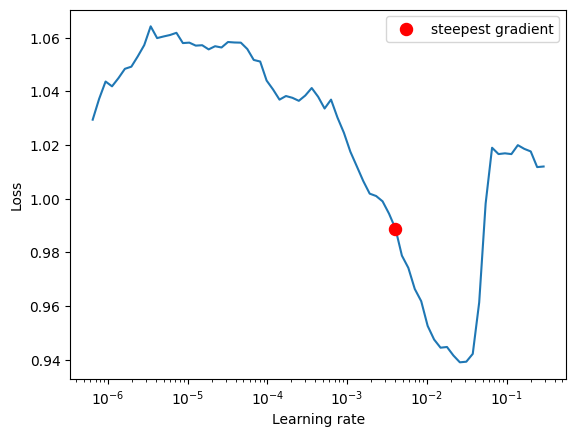

In [11]:
lr_finder.plot()  
plt.show()

##  Now we can start to train

In [12]:
seq_model = SeqModel(in_ch=len(train_dataset[0][0]), out_ch = len(train_dataset[0][1]), lr = lr)

#logger = pl_loggers.TensorBoardLogger("./logs", name = "Simple")

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=NUM_EPOCHS,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
#trainer.test(seq_model, dataloaders=test_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-12-19 13:09:35.035086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734602975.056864 3840214 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734602975.063542 3840214 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attemp


---------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 1.13068 | val_pearson: 0.06903 |
---------------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.99587 | val_pearson: 0.24517 |
---------------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 1.00000 | val_loss: 1.32181 | val_pearson: 0.34468 |
---------------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 2.00000 | val_loss: 1.16697 | val_pearson: 0.38407 |
---------------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 3.00000 | val_loss: 3.39381 | val_pearson: 0.46688 |
-----------

`Trainer.fit` stopped: `max_epochs=50` reached.



----------------------------------------------------------------------
| current_epoch: 49.00000 | val_loss: 0.45042 | val_pearson: 0.68967 |
----------------------------------------------------------------------



In [13]:
# итерируемся по батчу и загружаем таргеты
targets = []
for i, batch in enumerate(test_loader):
    x, y = batch
    targets.append(y)
targets = torch.tensor(torch.concat(targets).cpu().numpy())

# делаем предсказания для прямой и обратно комплементарной цепи
y_preds = trainer.predict(seq_model, dataloaders=test_loader)
y_preds = torch.concat(y_preds).cpu().numpy()

y_preds_rev =  trainer.predict(seq_model, dataloaders=test_loader_rev)
y_preds_rev = torch.concat(y_preds_rev).cpu().numpy()

# усредняем предсказания для прямой и обратной цепей
preds = torch.ones([targets.shape[0], targets.shape[1]])
for i in range(len(y_preds[0])):
    preds[:,i] = torch.tensor((y_preds[:,i] + y_preds_rev[:,i]) / 2)

# считаем корреляцию
pearson_correlation(preds, targets)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.7699)